In [1]:
# similar to https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../../fastai'))) # fast ai library is in here
from IPython.core.interactiveshell import InteractiveShell

In [4]:
#InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last_expr"

In [6]:
from fastai.imports import *

In [7]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [8]:
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.3.0.post4


In [9]:
use_cuda = torch.cuda.is_available()
use_cuda
torch.backends.cudnn.enabled

True

In [10]:
arch = vgg16 # fastai has a bit modified vgg16, it has batch norm added

# Load datasets

In [11]:
img_size = 100
batch_size = 32
data_dir = 'data'

In [12]:
# Transformations that are used to the image
#transforms = tfms_from_model(arch, img_size) # only default normalization

# Some flipping and rotation included
transforms = tfms_from_model(arch, img_size, aug_tfms=transforms_side_on, max_zoom=1.1)
print(type(transforms[0]))
print(transforms[0])
print(transforms[1])

<class 'fastai.transforms.Transforms'>
[<fastai.transforms.RandomScale object at 0x7f1db62aee10>, <fastai.transforms.RandomRotate object at 0x7f1dbcae3438>, <fastai.transforms.RandomLighting object at 0x7f1dbcae34a8>, <fastai.transforms.RandomFlip object at 0x7f1dbcae34e0>, <fastai.transforms.RandomCrop object at 0x7f1db62aee80>, <fastai.transforms.Normalize object at 0x7f1db62aec88>, <fastai.transforms.ChannelOrder object at 0x7f1db62aeeb8>]
[<fastai.transforms.Scale object at 0x7f1db62aed30>, <fastai.transforms.CenterCrop object at 0x7f1db62aeda0>, <fastai.transforms.Normalize object at 0x7f1db62aec88>, <fastai.transforms.ChannelOrder object at 0x7f1db62aedd8>]


In [13]:
data = ImageClassifierData.from_paths(data_dir, tfms=transforms, num_workers=4)
print(data)
print(f'Classes: {data.classes}')
print(f'Trn labels: {data.trn_y[0]}')
print(f'Trn file names: {data.trn_ds.fnames[0:2]}')

Classes: ['cats', 'dogs']
Trn labels: 0
Trn file names: ['train/cats/cat.3227.jpg', 'train/cats/cat.5010.jpg']


In [14]:
it = iter(data.trn_dl)

In [15]:
batch, batch_y = next(it)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of images in the batch: torch.Size([64, 3, 100, 100])
First image plot: 
Img target: 0, Class: cats


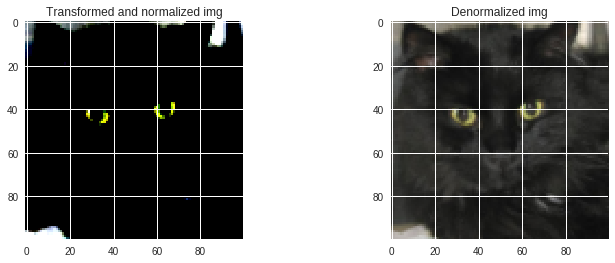

In [16]:
i = 1
sample = batch[i]
print("Shape of images in the batch: " + str(batch.shape))
print("First image plot: ")
print(f'Img target: {batch_y[i]}, Class: {data.classes[batch_y[i]]}')
tmp = sample.cpu().numpy().transpose(1,2,0)
fig, axs = plt.subplots(1,2,figsize=(12,4))
plt.sca(axs[0])
plt.title('Transformed and normalized img')
plt.imshow(tmp)
plt.sca(axs[1])
plt.title('Denormalized img')
plt.imshow(transforms[0].denorm(tmp));

# Model and Training

### Find out learning rate

In [19]:
lr_learn = ConvLearner.pretrained(arch, data, precompute=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


 56%|█████▌    | 44/79 [00:00<00:00, 56.08it/s, loss=2.69] 


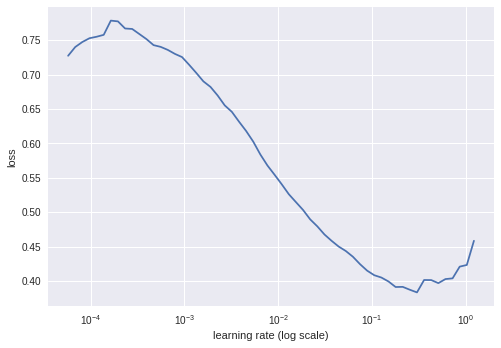

In [20]:
lr_learn.lr_find()
lr_learn.sched.plot()
lr_learn.sched

In [21]:
lr = 1e-2 # from graph aboce check highest learning rate where loss is still improving clearly

In [22]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
print(type(learn))
print(learn)

<class 'fastai.conv_learner.ConvLearner'>
Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=2)
  (7): LogSoftmax()
)


### Finetuning last layers

In [23]:
learn.fit(lr, 10, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy                  
    0      0.182997   0.104041   0.9608    
    1      0.12896    0.083884   0.966                     
    2      0.116264   0.078794   0.9692                     
    3      0.127407   0.081926   0.9688                    
    4      0.11399    0.080577   0.9688                     
    5      0.102709   0.081346   0.9696                      
    6      0.093081   0.069687   0.9728                     
    7      0.08397    0.073759   0.9716                      
    8      0.107471   0.08738    0.9648                     
    9      0.091341   0.069934   0.972                      



[array([ 0.06993]), 0.97199999999999998]

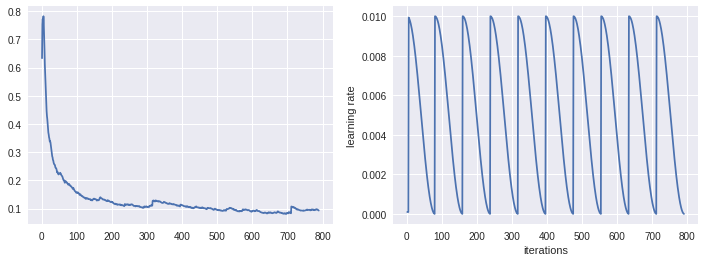

In [24]:
type(learn.sched)
fig, axs = plt.subplots(1,2,figsize=(12,4))
plt.sca(axs[0])
learn.sched.plot_loss(0, 1)
plt.sca(axs[1])
learn.sched.plot_lr()

### Training rest of the model

In [25]:
learn.unfreeze()

In [26]:
lr_whole=np.array([lr/1000,lr/100,lr/10])

In [27]:
learn.fit(lr_whole, 3, cycle_len=1, cycle_mult=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy                   
    0      0.135798   0.074049   0.9728    
    1      0.117001   0.068206   0.9732                    
    2      0.113      0.068094   0.9736                    
    3      0.12674    0.068287   0.9728                    
    4      0.115998   0.068821   0.974                     
    5      0.107938   0.068563   0.9728                    
    6      0.110441   0.070415   0.9728                    



[array([ 0.07041]), 0.9728]

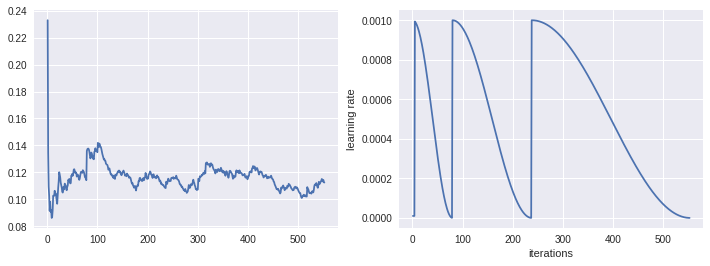

In [28]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
plt.sca(axs[0])
learn.sched.plot_loss(0, 1)
plt.sca(axs[1])
learn.sched.plot_lr()

# Some sample predictions

In [36]:
it = iter(data.trn_dl)

In [37]:
batch, batch_y = next(it)
batch = batch[0:6]
batch_y = batch_y[0:6]

In [38]:
results = learn.model(Variable(batch).cuda())

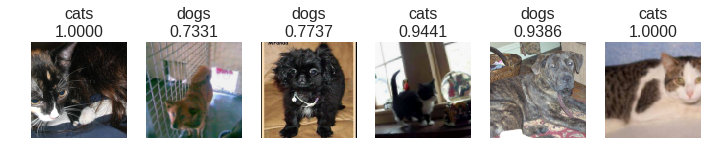

In [39]:
f = plt.figure(figsize=(12,5))
for i in range(len(results)):
    img = batch[i].cpu().numpy().transpose(1,2,0)
    img = transforms[1].denorm(img)
    class_idx = results[i].max(0)[1].data[0]
    score = F.softmax(results[i])[class_idx].data[0]
    img_title = "{}\n{:.4f}".format(data.classes[class_idx], score)
    #img_title = "asdf"
    sp = f.add_subplot(1, len(batch), i+1)
    sp.axis('Off')
    sp.set_title(img_title, fontsize=16)
    plt.imshow(img)